# This notebook creates the plots used in the presentation

In [2]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.axislines import Subplot
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

save_fig = style.save_fig
figure_path = style.figure_path

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
colors = style.colors

model = model_class.model()    
label_populations = hf.rlbl(model.populations)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


## Example of membrane dynamics

save figure to single_membrane_potential
save figure to single_membrane_potential_distribution


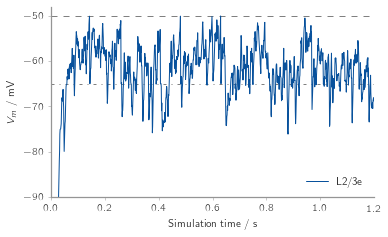

In [67]:
# DATA
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)


with h5py.File(path_res_file, "r") as res_file:
    res_grp = res_file["0"]
    
    dset_times_volt     = res_grp["times_volt"]
    times_volt = dset_times_volt[:]
    t_min_volt = dset_times_volt.attrs["t_min_volt"]
    t_max_volt = dset_times_volt.attrs["t_max_volt"]
    dt_volt    = dset_times_volt.attrs["dt_volt"]
    
    volt_plot         = res_grp["volt_plot"][:]
    volt_histo_single = res_grp["volt_histo_single"][:]
    volt_histo_means  = res_grp["volt_histo_means"][:]
    n_hist_max  = res_grp.attrs["n_hist_max"]
    V_min       = res_grp.attrs["V_min"]
    V_max       = res_grp.attrs["V_max"]
    n_bins_volt = res_grp.attrs["n_bins_volt"]
    n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]
    
bin_edges = np.linspace(V_min, V_max, n_bins_volt + 1) 

# Membrane potential over time

fig1= plt.figure()
fig1.set_size_inches(style.figsize[0], style.figsize[1])
ax1 = hf.add_subplot(fig1, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

# Histogram of membrane pot
# fig2 = plt.figure()
# fig2.set_size_inches(style.figsize[0]*0.45, style.figsize[1]) 
# ax2 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)


for i, population in enumerate(populations):
    # specific neuron to plot from (j < 10)
    j = 1

    # Choose populations to plot from
    pop1 = 0

    # two plots each
    if i==pop1: 
        ax_mpot = ax1
        ax_pdf  = ax2

    if i==pop1:
        # single membrane potential over time
        volt_single = volt_plot[i][j]
        ax_mpot.plot(times_volt, volt_single, 
                     '-', color=colors[i], linewidth=1., label=hf.rlbl(population))
        hf.resadjust(ax_mpot, yres=10.)
        # single histogram
        single_hist_normed = volt_histo_single[i, j] / np.sum(volt_histo_single[i, j])
        single_hist_normed = hf.adjust_steps(single_hist_normed)
        ax_pdf.plot(single_hist_normed, bin_edges[:-1], 
                    linewidth=1.0, color=colors[i], alpha=0.7, drawstyle="steps",
                    label="single neuron")
        # mean
#         hist_normed = volt_histo_means[i] / np.sum(volt_histo_means[i])
#         hist_normed = hf.adjust_steps(hist_normed)
#         ax_pdf.plot(hist_normed, bin_edges[:-1], 
#                     "-", linewidth=1., color=colors[i], drawstyle="steps",
#                     label="subset of " + hf.rlbl(population))

        hf.resadjust(ax_pdf, xres=0.01)

# Threshold and rest potential
y_max_histo = 0.035
xlim = np.array([t_min_volt, t_max_volt]) # s


for ax in [ax1]:
    ax.plot([0, times_volt[-1] + 1], [model.E_L + model.theta]*2, 
             "--", linewidth=1.0, color="gray", zorder=0 )#, label="$\\theta$")
    ax.plot([0, times_volt[-1] + 1], [model.E_L]*2, 
            "-.", linewidth=1.0, color="gray", zorder=0 )#, label="$E_L$")

    ax.set_ylabel('$V_m$ / mV')
    ax.set_xlim(*xlim)
    ax.set_ylim(-90, V_max + 2)
    ax.legend(loc=0)

ax1.set_xlabel('Simulation time / s')

# Histogram

for ax in [ax2]:

    ax.plot([0, y_max_histo*1.1], [model.E_L + model.theta]*2, 
             "--", linewidth=1., color="gray", zorder=0 )#, label="$\\theta$")
    ax.plot([0, y_max_histo*1.1], [model.E_L]*2, 
             "-.", linewidth=1., color="gray", zorder=0 )#, label="$E_L$")

    ax.set_ylim(-90, V_max + 2)
    ax.set_xlim(0, y_max_histo*1.1)
    ax.set_yticks([])
    #ax.legend(loc=0)

ax2.set_xlabel('$\mathrm{pdf}[X = V_m]$')
#ax2.set_xlabel('Membrane potential $V_m$ / mV')

fig_names = ("single_membrane_potential", "single_membrane_potential_distribution")
for fig, fig_name in zip((fig1, fig2), fig_names):
    for ax in fig.axes:
        style.fixticks(ax)    
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

## Raster plot

In [16]:
def plot_raster(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    with h5py.File(path_res_file, "r") as res_raster:
        ymax_raster = res_raster.attrs["ymax_raster"]
        yticks = res_raster.attrs["yticks"]

        for i, population in enumerate(populations):
            res_raster_pop = res_raster[str(population)]
            for times, neuron_ids in res_raster_pop.values():
                ax.plot(times * 1e3 - 100, neuron_ids, ',', ms=2, color=colors[i])              

    # Raster Plot
    yticks[2] = yticks[2] * 0.95
    yticks[3] = yticks[3] * 1.05
    
    xlim = (t_trans * 1e3 - 100, t_sim * 1e3 - 100) 
    ylim = (0, ymax_raster)
    xticks = np.linspace(0, 400, 5)
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Simulation time / ms')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

save figure to raster_plot
save figure to raster_plot_sli


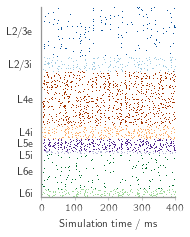

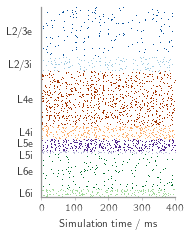

In [23]:
fig_names = ("raster_plot", "raster_plot_sli")

for sli, fig_name in zip([False, True], fig_names):
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0]*0.5, style.figsize[1]) 
    ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    raster_sim_spec = "raster_plot"
    if sli:
        raster_sim_spec += "_sli"
    #raster_plot_results(sim_spec=raster_sim_spec, reverse_order=reverse_order) # produces results file
    res_file_name = raster_sim_spec + "_res.hdf5"
    path_res_file = os.path.join(data_path, res_file_name)

    plot_raster(ax, path_res_file)

    # General rendering
    style.fixticks(ax)
    ax.yaxis.set_ticks_position('none') 
    
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

## Statistical comparison

In [24]:
def plot_data_cross(ax, path_res_file, 
                  data_type="rates_mean", 
                  reverse_order=True):
    """Plot means of rates, CV of ISI or synchrony.
    Plots results of n simulations in a box plot
    Default is firing rates.
    """
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    with h5py.File(path_res_file, "r") as res_file:
        n_runs = len(res_file.keys())
        data = np.zeros((n_runs, n_populations))
        for i_run in range(n_runs):
            res_grp = res_file[str(i_run)]
            data[i_run] = res_grp[data_type][:]            
    
    ys = np.arange(n_populations) + 0.5
    if reverse_order:
        ys = ys[::-1]
    for i, population in enumerate(populations):
        ax.plot(data[:, i], [ys[i]]*n_runs, "+", color=colors[i], mew=0.8, ms=style.cross_size)

    yticks = np.arange(n_types * 0.5, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)

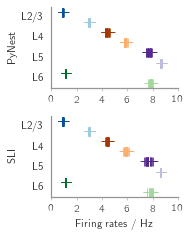

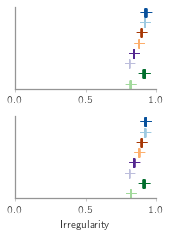

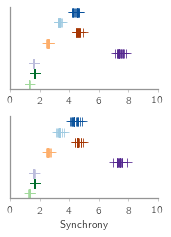

In [26]:
plot_data = plot_data_cross
fig_names = ("spon_act_rates", "spon_act_irregularity", "spon_act_synchrony")
fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()
fig1.set_size_inches(style.figsize[0]*0.5, style.figsize[1])
for fig in [fig2,fig3]: 
    fig.set_size_inches(style.figsize[0]*0.45, style.figsize[1])
ylabels = ("PyNest", "SLI")
    
for i, sli in enumerate([False, True]):
    # DATA
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    sim_spec = "spon_act_statistic"
    if sli:
        sim_spec += "_sli"
    data_file_name  = sim_spec + ".hdf5"  
    res_file_name = sim_spec + "_res.hdf5"
    path_data_file = os.path.join(data_path, data_file_name)
    path_res_file = os.path.join(data_path, res_file_name)

    # # Rates
    ax1 = hf.add_subplot(fig1, n_rows_cols=(2, 1), index_row_col=(i, 0), rowspan=1, colspan=1)
    data_type="rates_mean"
    plot_data(ax1, path_res_file, data_type, reverse_order)
    ax1.set_ylabel(ylabels[i])
    hf.resadjust(ax1, xres=2)
    
    # CV of interspike interval (ISI)
    ax2 = hf.add_subplot(fig2, n_rows_cols=(2, 1), index_row_col=(i, 0), rowspan=1, colspan=1)
    data_type="cv_isi_mean"
    plot_data(ax2, path_res_file, data_type, reverse_order)
    ax2.set_xlim(0, 1)
    hf.resadjust(ax2, xres=0.5)
    ax2.set_yticks([])

    # # Synchrony
    ax3 = hf.add_subplot(fig3, n_rows_cols=(2, 1), index_row_col=(i, 0), rowspan=1, colspan=1)
    data_type="synchrony"
    plot_data(ax3, path_res_file, data_type, reverse_order)
    ax3.set_xlim(0, 9.)
    hf.resadjust(ax3, xres=2)
    ax3.set_yticks([])

ax1.set_xlabel("Firing rates / Hz")   
ax2.set_xlabel("Irregularity")   
ax3.set_xlabel("Synchrony")

# Label subfigures
for fig, fig_name in zip([fig1, fig2,fig3], fig_names):  
    for ax in fig.axes:
    # General rendering
        style.fixticks(ax)
        ax.yaxis.set_ticks_position('none') 
    
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Single neuron activity

In [6]:
def box_plot(ax, data, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    """Data has to be in the right order (will not be reversed)"""
    
    boxprops = dict(linewidth=0.5, color=style.text_color)
    flierprops  = dict(marker='+', markersize=style.cross_size*0.5,
                      linestyle='None', mew=0.5)
    medianprops = dict(color=style.text_color, linewidth=0.5)
    meanprops  = dict(marker='*', markersize=4, 
                      mec='0.95', #style.text_color, 
                      markerfacecolor='0.95', #style.text_color,
                      linestyle='None', mew=0.5)

    
    box = ax.boxplot(data,
                     vert=False, showfliers=True, showmeans=True,
                     boxprops=boxprops,
                     flierprops=flierprops, medianprops=medianprops,
                     meanprops=meanprops,
                     patch_artist=True)

    if reverse_order:
        box_colors = colors[::-1]
    else:
        box_colors = colors[:]        

    for i, population in enumerate(populations):
        box["boxes"][i].set_alpha(0.8)
        box["boxes"][i].set_facecolor(box_colors[i])
        #box["boxes"][i].set_color(box_colors[i])
        box["fliers"][i].set_color(box_colors[i])
        box["whiskers"][2*i].set_color(box_colors[i])
        box["whiskers"][2*i+1].set_color(box_colors[i])
        box["caps"][2*i].set_color(box_colors[i])
        box["caps"][2*i+1].set_color(box_colors[i])

    yticks = np.arange(n_types * 0.75, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations + 1.0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)   

In [7]:
def plot_single_rates(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_rates = np.empty((n_populations, n_spikes_recorded))
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_rates"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_rates[-(i + 1)] = res_grp[population][:]
            else:
                single_rates[i] = res_grp[population][:]

    box_plot(ax, single_rates.T, path_res_file, reverse_order)
    
    ax.set_xlabel("Single neuron firing rates / Hz")

In [8]:
def plot_single_CV_ISI(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_cv_isi = [[]] * n_populations
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_cv_isi"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_cv_isi[-(i + 1)] = res_grp[population][:]
                print(population, len(single_cv_isi[-(i + 1)]))
            else:
                single_cv_isi[i] = res_grp[population][:]
                print(population, len(single_cv_isi[i]))
    
    box_plot(ax, single_cv_isi, path_res_file, reverse_order)
    
    ax.set_xlabel("Irregularity")

/export/data-schuessler/data_microcircuit/micro/spon_act_statistic_res.hdf5
L23e 982
L23i 999
L4e 999
L4i 999
L5e 999
L5i 999
L6e 970
L6i 999
save figure to single_neuron_activity_rates
save figure to single_neuron_activity_irregularity


/usr/local/lib/python3.4/dist-packages/matplotlib/patches.py:102: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


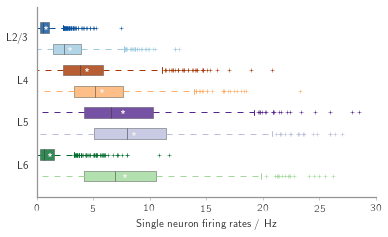

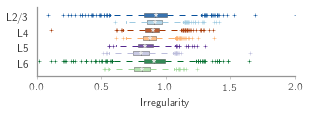

In [9]:
# DATA
data_path = "/export/data-schuessler/data_microcircuit/micro"
sim_spec = "spon_act_statistic"
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
print(path_res_file)

fig_names = ("single_neuron_activity_rates", "single_neuron_activity_irregularity")

# Rates
fig1 = plt.figure()
fig1.set_size_inches(style.figsize[0], style.figsize[1])
ax1 = hf.add_subplot(fig1, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_single_rates(ax1, path_res_file, n_spikes_recorded=1000)

# CV of interspike interval (ISI)
fig2 = plt.figure()
fig2.set_size_inches(style.figsize[0]*0.8, style.figsize[1]*0.5)
ax2 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_single_CV_ISI(ax2, path_res_file, n_spikes_recorded=1000)
ax2.set_xlim(0, 2)
  
for fig, fig_name in zip((fig1, fig2), fig_names):
    for ax in fig.axes:
        style.fixticks(ax)   
        ax.yaxis.set_ticks_position('none') 
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

## Mean field vs. simulation: rates

In [3]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        return sol["x"]
    else:   
        raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf, erfcx
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        return np.exp(x**2) * np.exp(-u**2) * erfcx(-u)**2
    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * dbl_integral) * v0 * model.tau_m * 1e-3 # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [4]:
def plot_compare_sim_mf(data_sim, data_mf, ax):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=0.5, ms=style.cross_size)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.4) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=1, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
    ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=1., ms=style.cross_size / style.legend_ms) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

In [8]:
######################################################
# Mean field results
######################################################

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
jacobian=True
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model_micro, v_guess_0,
                          jacobian=jacobian,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model_micro)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA
sim_spec = "spon_act_statistic"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all  = np.zeros((n_sims, n_populations))
    cv_isi_mean_all = np.zeros((n_sims, n_populations))
    synchrony_all   = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        synchrony_all[j]    = res_grp["synchrony"][:]

Use jacobian
Integration time: 0.06
CV calc time: 0.64


save figure to compare_sim_mf_fixed_total_number_rates
save figure to compare_sim_mf_fixed_total_number_irregularity


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


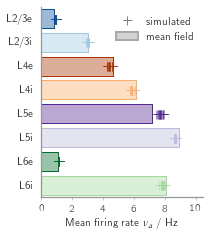

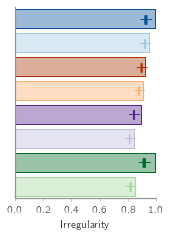

In [5]:
######################################################
# Plotting
######################################################
fig_names = ("compare_sim_mf_fixed_total_number_rates", "compare_sim_mf_fixed_total_number_irregularity")

fig1 = plt.figure()
fig1.set_size_inches(style.figsize[0]*0.55, style.figsize[1]) 
ax1 = hf.add_subplot(fig1, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
fig2 = plt.figure()
fig2.set_size_inches(style.figsize[0]*0.45, style.figsize[1]) 
ax2 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean firing rate $\\nu_a$ / Hz")
ax1.set_xlim(0, 10.5)
ax1.legend(loc="best")
    
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)
ax2.set_yticks([])

for fig, fig_name in zip((fig1, fig2), fig_names):
    for ax in fig.axes:
        style.fixticks(ax)   
        ax.yaxis.set_ticks_position('none') 
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

## Mean field vs. simulation: membrane potentials

Run "solve_model" above

In [5]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

In [9]:
def plot_membrane_potential(path_res_file, rate_mf, 
                            figname="membrane_potential"):
    # Model
    connection_rule = "fixed_indegree"
    weight_rel_sd   = 0.1 # 0.1 for micro
    model           = model_class.model(connection_rule=connection_rule,
                                               weight_rel_sd=weight_rel_sd) 

    # Get voltage data
    with h5py.File(path_res_file, "r") as res_file:
        sim_spec2 = "0"
        res_grp = res_file[sim_spec2]
        # Rates
        rates_mean   = res_grp["rates_mean"][:]
        rates_std    = res_grp["rates_std"][:]
        # Voltage
        dset_times_volt     = res_grp["times_volt"]
        t_min_volt = dset_times_volt.attrs["t_min_volt"]
        t_max_volt = dset_times_volt.attrs["t_max_volt"]
        dt_volt    = dset_times_volt.attrs["dt_volt"]
        volt_histo_means  = res_grp["volt_histo_means"][:]
        V_min       = res_grp.attrs["V_min"]
        V_max       = res_grp.attrs["V_max"]
        n_bins_volt = res_grp.attrs["n_bins_volt"]
        n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]

    # Input according to Brunel
    mu_brunel   = model.mu(rate_mf)
    sd_brunel   = model.sd(rate_mf)
    # and with simulated input
    mu_sim      = model.mu(rates_mean)
    sd_sim      = model.sd(rates_mean)
    
    # Voltage: Index of V = E_L
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)
    V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
    n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins
    V_range_plot = [-80, V_max + 1]

    # Figure
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0]*1.2, style.figsize[1]*1.2) 
    
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    
    ymax = 0.17 # max height for each population
    # Labels
    marker_sim = "-"
    marker_mf  = "-"
    #ax1.plot([0, 0], [0, 0], marker_sim, color="gray", label="simulated") 
    #ax1.plot([0, 0], [0, 0], marker_mf, color="gray", label="mean field", linewidth=3.0)

    for i, population in enumerate(populations):
        # Remove neurons in refractory period
        with h5py.File(path_res_file, "r") as res_file:
            single_rates = res_file["0/single_rates/" + population][:n_neurons_rec_voltage[i]]
        P_V_data =  volt_histo_means[i].copy()
        P_V_data[V_r_arg] -= np.sum(single_rates) * model.t_ref * n_t

        # Normalization
        norm_factor = n_t * n_neurons_rec_voltage[i] * V_step
        P_V_data_normed = P_V_data / norm_factor
        
        # Theoretical distirbution using Brunel's mu and sd but measured rate v0
        #P_V_theo = prob_V(V_array, mu_sim[i], sd_sim[i], rates_mean[i], model=model)
        P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)

        # Calculate integral of P_theo(V)
        P_cum = np.sum(P_V_data_normed) * V_step
        P_cum_theo = np.sum(P_V_theo) * V_step
        
        # Adjust histogram for "steps"
        P_V_data_normed = hf.adjust_steps(P_V_data_normed)

        # Plotting
        if reverse_order:
            offset = (n_populations - (i + 1)) * ymax
        else:
            offset = i * ymax
        ax1.plot(V_array, P_V_data_normed + offset, 
                 marker_sim, linewidth=1.5, color=colors[i], drawstyle="steps")
        ax1.plot(V_array, P_V_theo + offset, marker_mf, linewidth=1.0, color=colors[i])
        ax1.plot(V_range_plot, [offset]*2, "-", color=style.axes_color, linewidth=0.5) # line indicating P = 0

    # Resting potential and treshhold
    #ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
    #         "--", linewidth=1.5, color="gray", zorder=0 )#, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=1.5, color="darkgray", alpha=0.5, zorder=0 )#, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, n_populations * ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.grid(False)
    ax1.legend(loc='best')

    # Create ticks manually
    n_ticks = 3 
    ytickmax = ymax - 0.02
    yto           = np.arange(0, ytickmax, ytickmax/n_ticks)
    yto_str = ["%.2f"%ytoi for ytoi in yto]
    yt_offset     = np.repeat(np.arange(0,  n_populations * ymax, ymax), n_ticks)
    y_ticks = np.tile(yto, n_populations) + yt_offset
    y_ticklabels = np.tile(yto_str, n_populations)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)   

    for ax in fig.axes:
        style.fixticks(ax)
    
    # Population labels
    ax2 = ax1.twinx()
    ax2.set_ylabel('Population')
    ax2.set_yticks(np.arange(0.5, 8, 1)* ymax) 
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax2.set_yticklabels(yticklabels)
    ax2.set_ylim(0, n_populations * ymax)
    ax2.yaxis.set_ticks_position('none') 
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.grid(False)
        
    if save_fig:
        hf.saving_fig(fig, figure_path, figname, verbose=False)  

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


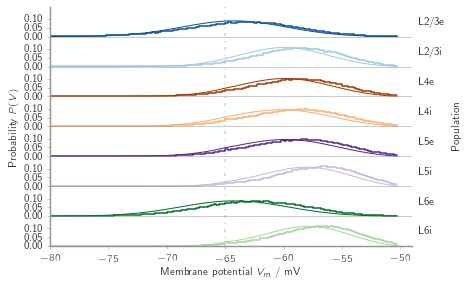

In [10]:
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential(path_res_file, rate_mf, figname="membrane_potential")

In [12]:
path_res_file

'/export/data-schuessler/data_microcircuit/micro/membrane_potential_res.hdf5'

In [21]:
def plot_membrane_potential_single(path_res_file, rate_mf, figname):
    # Model
    connection_rule = "fixed_indegree"
    weight_rel_sd   = 0.1 # 0.1 for micro
    model           = model_class.model(connection_rule=connection_rule,
                                               weight_rel_sd=weight_rel_sd) 

    # Get voltage data
    with h5py.File(path_res_file, "r") as res_file:
        sim_spec2 = "0"
        res_grp = res_file[sim_spec2]
        # Rates
        rates_mean   = res_grp["rates_mean"][:]
        rates_std    = res_grp["rates_std"][:]
        # Voltage
        dset_times_volt     = res_grp["times_volt"]
        t_min_volt = dset_times_volt.attrs["t_min_volt"]
        t_max_volt = dset_times_volt.attrs["t_max_volt"]
        dt_volt    = dset_times_volt.attrs["dt_volt"]
        volt_histo_means  = res_grp["volt_histo_means"][:]
        V_min       = res_grp.attrs["V_min"]
        V_max       = res_grp.attrs["V_max"]
        n_bins_volt = res_grp.attrs["n_bins_volt"]
        n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]

    # Input according to Brunel
    mu_brunel   = model.mu(rate_mf)
    sd_brunel   = model.sd(rate_mf)
    # and with simulated input
    mu_sim      = model.mu(rates_mean)
    sd_sim      = model.sd(rates_mean)
    
    # Voltage: Index of V = E_L
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)
    V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
    n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins
    V_range_plot = [-80, V_max + 1]

    # Figure
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0], style.figsize[1]) 
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    
    i = 4
    population = populations[i]

    # Remove neurons in refractory period
    with h5py.File(path_res_file, "r") as res_file:
        single_rates = res_file["0/single_rates/" + population][:n_neurons_rec_voltage[i]]
    P_V_data =  volt_histo_means[i].copy()
    P_V_data[V_r_arg] -= np.sum(single_rates) * model.t_ref * n_t

    # Normalization
    norm_factor = n_t * n_neurons_rec_voltage[i] * V_step
    P_V_data_normed = P_V_data / norm_factor

    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)

    # Adjust histogram for "steps"
    P_V_data_normed = hf.adjust_steps(P_V_data_normed)

    # Plotting
    ymax = 0.17 # max height for each populatio
    # Labels
    marker_sim = "-"
    marker_mf  = "-"
    ax1.plot(V_array, P_V_data_normed, 
             marker_sim, linewidth=1.5, color=colors[i], drawstyle="steps")
    ax1.plot(V_array, P_V_theo, marker_mf, linewidth=1.5, color=colors[i], label=hf.rlbl(population))

        
    # Resting potential and treshhold
    ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
             "--", linewidth=1.5, color="darkgray", zorder=0 )#, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=1.5, color="darkgray", alpha=0.5, zorder=0 )#, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.grid(False)
    ax1.legend(loc='best')

    for ax in fig.axes:
        style.fixticks(ax)
        
    if save_fig:
        hf.saving_fig(fig, figure_path, figname, verbose=True)  

save figure to membrane_potential_single


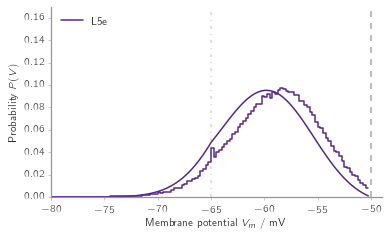

In [22]:
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential_single(path_res_file, rate_mf, figname="membrane_potential_single")

In [65]:
def plot_solution(path_res_file, rate_mf, 
                            figname="solution"):
    # Model
    connection_rule = "fixed_indegree"
    weight_rel_sd   = 0.1 # 0.1 for micro
    model           = model_class.model(connection_rule=connection_rule,
                                               weight_rel_sd=weight_rel_sd) 

    # Get voltage data
    with h5py.File(path_res_file, "r") as res_file:
        sim_spec2 = "0"
        res_grp = res_file[sim_spec2]
        # Rates
        rates_mean   = res_grp["rates_mean"][:]
        rates_std    = res_grp["rates_std"][:]
        # Voltage
        dset_times_volt     = res_grp["times_volt"]
        t_min_volt = dset_times_volt.attrs["t_min_volt"]
        t_max_volt = dset_times_volt.attrs["t_max_volt"]
        dt_volt    = dset_times_volt.attrs["dt_volt"]
        volt_histo_means  = res_grp["volt_histo_means"][:]
        V_min       = res_grp.attrs["V_min"]
        V_max       = res_grp.attrs["V_max"]
        n_bins_volt = res_grp.attrs["n_bins_volt"]
        n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]

    # Input according to Brunel
    mu_brunel   = model.mu(rate_mf)
    sd_brunel   = model.sd(rate_mf)
    # and with simulated input
    mu_sim      = model.mu(rates_mean)
    sd_sim      = model.sd(rates_mean)
    
    # Voltage: Index of V = E_L
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)
    V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
    n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins
    V_range_plot = [-80, V_max + 1]

    # Figure
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0], style.figsize[1]*(6./8.)) 
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    

    i = 7
    population = populations[i]
    
    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)

    # Calculate integral of P_theo(V)
    P_cum_theo = np.sum(P_V_theo) * V_step

    # Plotting
    ymax = 0.17 # max height for each populatio
    
    ax1.plot(V_array, P_V_theo, "-", linewidth=1.5, color=colors[6])
        
    # Resting potential and treshhold
    ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
             "--", linewidth=1.5, color="darkgray", zorder=0 )#, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=1.5, color="darkgray", alpha=0.5, zorder=0 )#, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.grid(False)
    ax1.legend(loc='best')

    for ax in fig.axes:
        style.fixticks(ax)
        
    if save_fig:
        hf.saving_fig(fig, figure_path, figname, verbose=True)  

save figure to solution


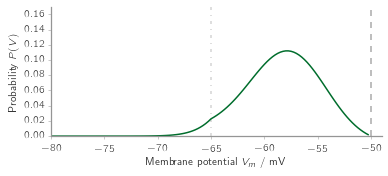

In [66]:
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_solution(path_res_file, rate_mf, figname="solution")

## Applying mean field theory

In [68]:
g_step      = 0.1
g_low       = 3 
g_up        = 10
n_low       = int((4 - g_low) / g_step) + 1
n_up        = int((g_up - 4) / g_step) + 1
n           = n_low + n_up
gs_low      = np.linspace(4, g_low, n_low, -1)
gs_up       = np.linspace(4, g_up, n_up)
gs          = np.concatenate((gs_low, gs_up), axis=0)
rates       = np.zeros((n, n_populations))
cv_isis     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"

root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for j, g in enumerate(gs):
    if g == 4:
        v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
    model_micro     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        g=g) 
    t_rate0      = time.time()
    rates[j]     = solve_model(model_micro, v_guess_0,
                              root_method=root_method, options=options)
    t_rate1      = time.time() - t_rate0
    t_cv0        = time.time()
    cv_isis[j]   = CV_ISI_mf(rate_mf, model=model_micro)
    t_cv1        = time.time() - t_cv0
    
    v_guess_0 = rates[j]
    if g==8:
        print("g=8")
        v_g8 = rates[j]
    #print("{0:2d}\t{1:6.2f}\t{2:8.2f} s\t{3:8.2f} s".format(j, g, t_rate1, t_cv1))


g=8


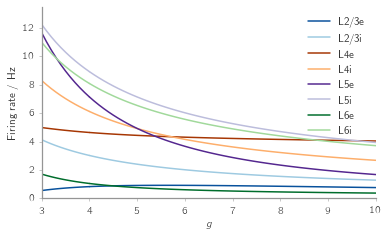

In [76]:
# Plotting
fig = plt.figure()
fig.set_size_inches(style.figsize[0], style.figsize[1]) 
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
#ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(populations):
    n_low = np.sum(gs < 4)
    ax1.plot(gs[:n_low+1], rates[:n_low+1, i], linestyle='-', linewidth=1.5, color=colors[i],
        label=hf.rlbl(population))
    ax1.plot(gs[n_low+1:], rates[n_low+1:, i], linestyle='-', linewidth=1.5, color=colors[i])
#     ax2.plot(rs, rates2[:, i], linestyle='-',  color=colors[i],
#         label=hf.rlbl(population))
    
ax1.set_ylabel("Firing rate / Hz")
ax1.set_ylim(0, 13.5)
ax1.set_xlabel("$g$")

# ax2.set_ylabel("CV of ISI")
# #ax2.set_yscale("log")
# #ax2.set_ylim(ax2.get_ylim()[0], 100)
# ax2.set_xlabel(r"$\nu_\mathrm{ext}$")

ax1.legend(loc="best")

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "simulate_change_g"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Population size

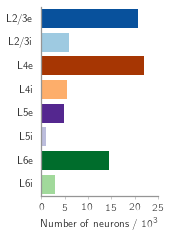

In [12]:
######################################################
# Population size
######################################################
fig2 = plt.figure()
fig2.set_size_inches(style.figsize[0]*0.45, style.figsize[1]) 
ax3 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

bar_edges = np.arange(0, 8, 1) + 0.1
if reverse_order:
    bar_edges = bar_edges[::-1]
ticks=np.arange(0.5, 8., 1)

for i in range(8):
    ax3.barh(bar_edges[i], model.n_neurons[i] * 1e-3, height=0.8, color=colors[i], linewidth=0)
ax3.set_yticks(ticks)
yticklabels = label_populations
if reverse_order:
    yticklabels = yticklabels[::-1]
ax3.set_yticklabels(yticklabels)
ax3.set_xlabel('Number of neurons / $10^3$') 
style.fixticks(ax3)
ax3.yaxis.set_ticks_position('none') 
    
fig_name    = "population_size"
if save_fig:
    hf.saving_fig(fig2, figure_path, fig_name, verbose=False) 

## Synapse numbers

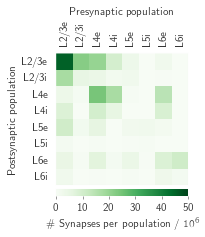

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

def plot_heatmap(ax, data, model, cbar_label, cbar_format, clim, cbar_ticks, cmap=cm.Greens):   
    extent = [0, 8, 0, 8]
    heatmap = ax.imshow(data, interpolation='none', extent=extent, cmap=cmap)
    
    # Color bar (with tight layout)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(heatmap, cax=cax, 
                        format=cbar_format, 
                        label=cbar_label, 
                        orientation='horizontal')

    cbar.set_ticks(cbar_ticks)
    cbar.outline.set_linewidth(0.2)
    #cbar.set_clim(*clim)
    heatmap.set_clim(*clim)
    
    # Set ticks: left and top
    ticks=np.arange(0.5, 8., 1)
    # xticks
    ax.set_xlabel('Presynaptic population')
    ax.xaxis.set_tick_params(labeltop='on')
    ax.xaxis.set_tick_params(labelbottom='off')
    ax.xaxis.set_label_position("top")
    ax.set_xticks(ticks)
    ax.set_xticklabels(label_populations, rotation=90)
    # yticks
    ax.yaxis.set_tick_params(labelbottom='off')
    
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.01)
        ax.spines[axis].set_color('0.9')
    cbar.outline.set_linewidth(0.01)

    ax.grid(False)      # Turn of grid (distracts!)
    
    
# Figure
fig = plt.figure()
fig.set_size_inches(style.figsize[0], style.figsize[1]) 
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

######################################################
# Total synapse numbers
######################################################
data = model.C_ab * 1e-6
cbar_label  = "\# Synapses per population / $10^{6}$"
cbar_format = "%i"
clim        = (0, 50)
cbar_ticks  = np.arange(0, 60, 10)
plot_heatmap(ax1, data, model, cbar_label, cbar_format, clim, cbar_ticks)   
    
######################################################
# Synapse numbers per neuron
######################################################
# data = (model.C_ab.T / (model.n_neurons * model.area)).T
# cbar_label  = "Mean \# synapses per neuron"
# cbar_format = "%i"
# clim        = (0, 3500)
# cbar_ticks  = np.arange(0, 4000, 1000)
# plot_heatmap(ax2, data, model, cbar_label, cbar_format, clim, cbar_ticks)

# y ticks
ticks=np.arange(0.5, 8., 1)
label_populations = hf.rlbl(model.populations)
ax1.yaxis.set_tick_params(labelbottom='on')
ax1.set_ylabel('Postsynaptic population')
ax1.set_yticks(ticks)
ax1.set_yticklabels(label_populations[::-1])

fig_name    = "synapse_numbers"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False)   